<a href="https://colab.research.google.com/github/ua-datalab/Geospatial_Workshops/blob/main/notebooks/deepforest_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Tree Detection with DeepForest

This jupyter notebook uses the python library DeepForest to identify and put bounding boxes around trees.

If using the software, please cite as:
Geographic Generalization in Airborne RGB Deep Learning Tree Detection Ben. G. Weinstein, Sergio Marconi, Stephanie A. Bohlman, Alina Zare, Ethan P. White bioRxiv 790071; doi: https://doi.org/10.1101/790071

Documentation for DeepForest can be found at https://deepforest.readthedocs.io/en/latest/index.html

In [1]:
#Install the deepforest python library. After installing, you may need to restart the kernel before moving to the next code snippet
!pip install DeepForest --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 86.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 48.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.5/39.5 MB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.7/21.7 MB 89.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 543.2/543.2 kB 39.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.1/51.1 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 869.2/869.2 kB 54.1 MB/s eta 0:00:00


In [2]:
##After restarting the kernel, import libraries into environment...
from deepforest import main
from deepforest import get_data
from deepforest.utilities import boxes_to_shapefile
from deepforest.utilities import shapefile_to_annotations
from deepforest.preprocess import split_raster
from deepforest.visualize import plot_predictions

import matplotlib.pyplot as plt
import os
import time
import numpy
import rasterio
import geopandas as gpd
from rasterio.plot import show
import torch


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.15 (you have 1.4.14). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [3]:
#Bring a DeepForest pretrained model into environment. It is trained to identify trees from aerial imagery
#It is located at https://github.com/weecology/DeepForest/releases/tag/1.0.0
model = main.deepforest()
model.use_release()

Reading config file: /usr/local/lib/python3.10/dist-packages/deepforest/data/deepforest_config.yml


Downloading: "https://download.pytorch.org/models/retinanet_resnet50_fpn_coco-eeacb38b.pth" to /root/.cache/torch/hub/checkpoints/retinanet_resnet50_fpn_coco-eeacb38b.pth
100%|██████████| 130M/130M [00:01<00:00, 96.6MB/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


No validation file provided. Turning off validation loop


NEON.pt: 129MB [00:04, 27.5MB/s]                           

Model was downloaded and saved to /usr/local/lib/python3.10/dist-packages/deepforest/data/NEON.pt
Loading pre-built model: https://github.com/weecology/DeepForest/releases/tag/1.0.0



/usr/local/lib/python3.10/dist-packages/deepforest/main.py:130: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(self.release_state_dict)

## Predict Tree Crowns on Raw (non-georeferenced images)

In [4]:
#Path for the image you want to ID trees.
#These are non-georeferenced single jpeg drone image located in Cyverse datastore

!wget https://data.cyverse.org/dav-anon/iplant/commons/cyverse_curated/Gillan_Ecosphere_2021/raw_images/May_2019/15-g2/100_0123/100_0123_0086.JPG
image_path = get_data("/content/100_0123_0086.JPG")

!wget https://data.cyverse.org/dav-anon/iplant/projects/cyverse_training/datalab/nextgen_geospatial/DJI_0184.jpeg
image_path2 = get_data("/content/DJI_0184.jpeg")

!wget https://data.cyverse.org/dav-anon/iplant/projects/cyverse_training/datalab/nextgen_geospatial/100_0407_0064.jpeg
image_path3 = get_data("/content/100_0407_0064.jpeg")

!wget https://data.cyverse.org/dav-anon/iplant/projects/cyverse_training/datalab/nextgen_geospatial/DJI_0468.jpeg
image_path4 = get_data("/content/DJI_0468.jpeg")

!wget https://data.cyverse.org/dav-anon/iplant/projects/cyverse_training/datalab/nextgen_geospatial/101_0472_0074.jpeg
image_path5 = get_data("/content/101_0472_0074.jpeg")


--2024-09-16 16:08:50--  https://data.cyverse.org/dav-anon/iplant/commons/cyverse_curated/Gillan_Ecosphere_2021/raw_images/May_2019/15-g2/100_0123/100_0123_0086.JPG
Resolving data.cyverse.org (data.cyverse.org)... 206.207.252.35
Connecting to data.cyverse.org (data.cyverse.org)|206.207.252.35|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8494591 (8.1M) [application/octet-stream]
Saving to: ‘100_0123_0086.JPG’

100_0123_0086.JPG   100%[===================>]   8.10M  4.72MB/s    in 1.7s    

2024-09-16 16:08:52 (4.72 MB/s) - ‘100_0123_0086.JPG’ saved [8494591/8494591]

--2024-09-16 16:08:52--  https://data.cyverse.org/dav-anon/iplant/projects/cyverse_training/datalab/nextgen_geospatial/DJI_0184.jpeg
Resolving data.cyverse.org (data.cyverse.org)... 206.207.252.35
Connecting to data.cyverse.org (data.cyverse.org)|206.207.252.35|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 447156 (437K) [application/octet-stream]
Saving to: ‘DJI_0184.

In [ ]:
#Identify and put bounding boxes around all trees in the image
#This will create a table showing image coordinates of every predicted tree
#The 'score' is the confidence that the prediction is correct. Values closer to 1 are better.
trees = model.predict_image(path=image_path3, return_plot = False)
trees

xmin   ymin   xmax   ymax label     score          image_path
0   107.0  323.0  176.0  385.0  Tree  0.619734  100_0407_0064.jpeg
1   143.0   69.0  180.0  105.0  Tree  0.554984  100_0407_0064.jpeg
2    55.0   23.0  109.0   80.0  Tree  0.527672  100_0407_0064.jpeg
3   509.0  233.0  541.0  262.0  Tree  0.503346  100_0407_0064.jpeg
4   557.0  188.0  599.0  228.0  Tree  0.497907  100_0407_0064.jpeg
5    65.0  231.0  122.0  294.0  Tree  0.458085  100_0407_0064.jpeg
6   142.0  142.0  172.0  174.0  Tree  0.440365  100_0407_0064.jpeg
7   114.0    0.0  141.0    8.0  Tree  0.393911  100_0407_0064.jpeg
8   101.0   58.0  135.0   92.0  Tree  0.386400  100_0407_0064.jpeg
9    37.0  218.0   76.0  250.0  Tree  0.372510  100_0407_0064.jpeg
10   26.0  310.0   55.0  337.0  Tree  0.366329  100_0407_0064.jpeg
11   18.0  357.0   45.0  388.0  Tree  0.364256  100_0407_0064.jpeg
12  608.0    0.0  647.0   27.0  Tree  0.348606  100_0407_0064.jpeg
13   84.0  122.0  114.0  149.0  Tree  0.348589  100_0407_0064.jpeg
14   40.0  275.0   72.0  308.0  Tree  0.306435  100_0407_0064.jpeg
15  210.0    0.0  256.0   16.0  Tree  0.299720  100_0407_0064.jpeg
16  103.0   98.0  124.0  121.0  Tree  0.292540  100_0407_0064.jpeg
17  568.0    7.0  607.0   47.0  Tree  0.278120  100_0407_0064.jpeg
18  518.0    0.0  568.0   18.0  Tree  0.230971  100_0407_0064.jpeg
19  523.0  469.0  551.0  479.0  Tree  0.219788  100_0407_0064.jpeg
20  583.0  234.0  605.0  258.0  Tree  0.210286  100_0407_0064.jpeg
21   39.0  384.0   72.0  418.0  Tree  0.207267  100_0407_0064.jpeg
22    0.0  179.0   20.0  224.0  Tree  0.205493  100_0407_0064.jpeg
23   33.0   85.0   65.0  129.0  Tree  0.198078  100_0407_0064.jpeg
24  535.0  333.0  595.0  394.0  Tree  0.196970  100_0407_0064.jpeg
25    0.0  450.0    8.0  476.0  Tree  0.188103  100_0407_0064.jpeg
26  584.0  291.0  622.0  329.0  Tree  0.177179  100_0407_0064.jpeg
27   77.0   90.0  106.0  119.0  Tree  0.174457  100_0407_0064.jpeg
28  560.0  246.0  583.0  270.0  Tree  0.172591  100_0407_0064.jpeg
29  118.0  185.0  155.0  220.0  Tree  0.126242  100_0407_0064.jpeg

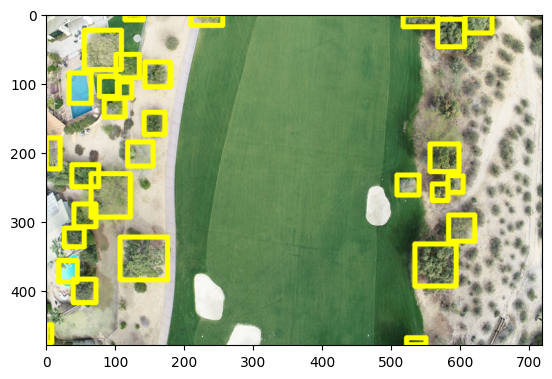

In [9]:
#Show the image with the bounding boxes
plot = model.predict_image(path=image_path3, return_plot = True, color=(0, 255, 255), thickness=6)
plt.imshow(plot[:,:,::-1])

## Predict Tree Crowns on Georeferenced Images

In [10]:
#Set the path for a georeferenced image you want to predict tree crowns

!wget https://data.cyverse.org/dav-anon/iplant/projects/cyverse_training/datalab/nextgen_geospatial/hole_17_ortho_utm.tif
raster_path = get_data("/content/hole_17_ortho_utm.tif")



--2024-09-16 16:12:22--  https://data.cyverse.org/dav-anon/iplant/projects/cyverse_training/datalab/nextgen_geospatial/hole_17_ortho_utm.tif
Resolving data.cyverse.org (data.cyverse.org)... 206.207.252.35
Connecting to data.cyverse.org (data.cyverse.org)|206.207.252.35|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 734371555 (700M) [application/octet-stream]
Saving to: ‘hole_17_ortho_utm.tif’

hole_17_ortho_utm.t 100%[===================>] 700.35M  21.3MB/s    in 35s     

2024-09-16 16:13:00 (20.2 MB/s) - ‘hole_17_ortho_utm.tif’ saved [734371555/734371555]



In [11]:
##Predict tree crowns on a georeferenced image
predicted_raster = model.predict_tile(raster_path, return_plot = True, patch_size=1000, patch_overlap=0.25, color=(255, 255, 0), thickness=20)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


5312 predictions in overlapping windows, applying non-max supression
3020 predictions kept after non-max suppression


/usr/local/lib/python3.10/dist-packages/deepforest/visualize.py:118: UserWarning: Input images must be channels last format [h, w, 3] not channels first [3, h, w], using np.rollaxis(image, 0, 3) to invert!
  warnings.warn("Input images must be channels last format [h, w, 3] not channels "


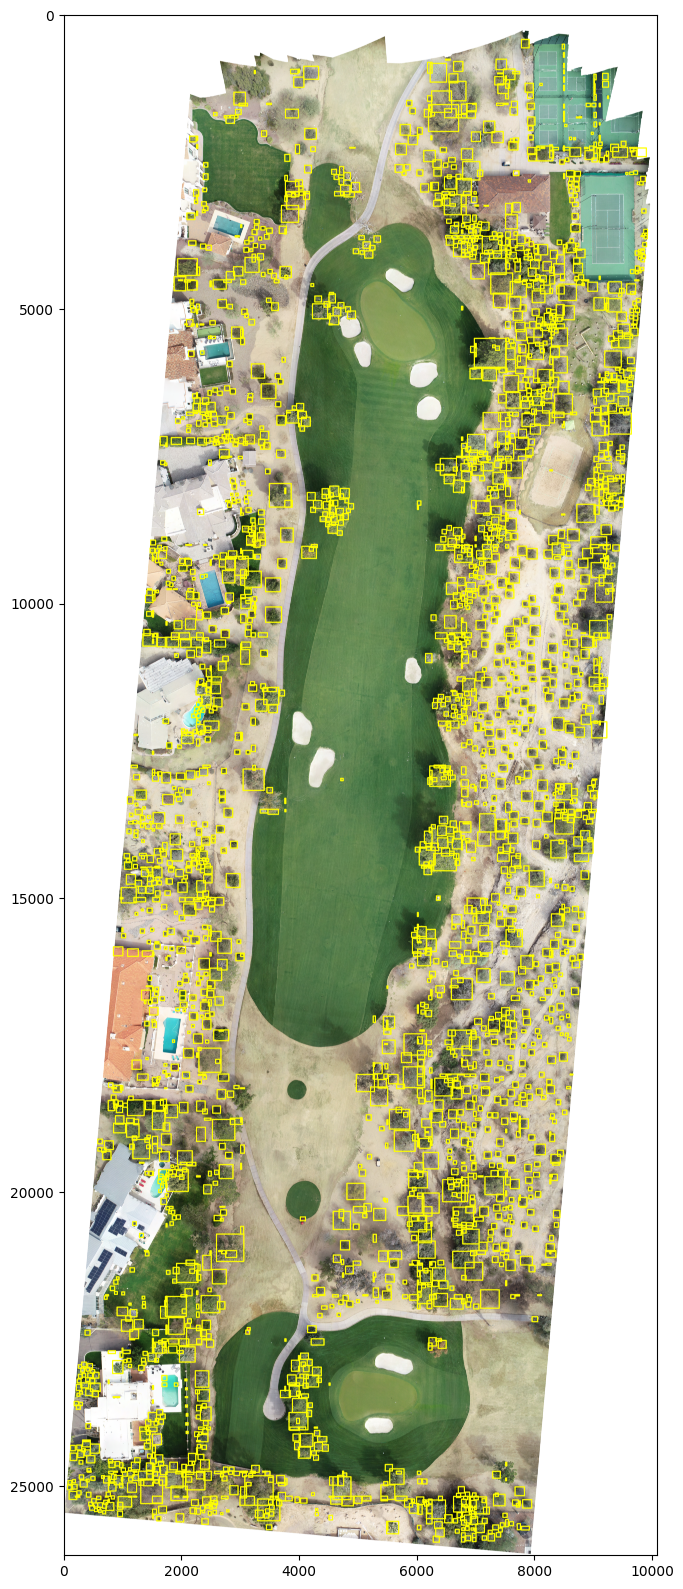

In [12]:
plt.figure(figsize=(20, 20))
plt.imshow(predicted_raster)
plt.show()

## Improve Model with Training
If the pre-trained model does not identify all trees correclty, then we want to improve the model by adding some training data and fine-tuning the model.
Manual labeling of trees (bounding boxes) can be done in QGIS. The output should be a polygon shapefile (.shp). Instructions for using QGIS is [here](https://github.com/ua-datalab/Geospatial_Workshops/wiki/Drone-Image-Analysis-%E2%80%90-Deep-Forest)

In [13]:
#Define data paths in preparation to convert .shp to annotation dataframe that can be used for training
## I have found that it is important that the orthomosaic and shapefiles used should have map projections (e.g., UTM). Otherwise, there will be a shift problem in the `shapefile_to_annotations` step.

# training data imagery path
# We are using the golf course orthomosaic geotiff
train_image_path = get_data("/content/hole_17_ortho_utm.tif")

# the directory that has the training data imagery
train_image_dir = os.path.dirname(train_image_path)

# the name of the training imagery
image_name = os.path.basename(train_image_path)

# shapefile path
!wget https://data.cyverse.org/dav-anon/iplant/projects/cyverse_training/datalab/nextgen_geospatial/golf_train_utm.shp
!wget https://data.cyverse.org/dav-anon/iplant/projects/cyverse_training/datalab/nextgen_geospatial/golf_train_utm.shx
!wget https://data.cyverse.org/dav-anon/iplant/projects/cyverse_training/datalab/nextgen_geospatial/golf_train_utm.dbf
!wget https://data.cyverse.org/dav-anon/iplant/projects/cyverse_training/datalab/nextgen_geospatial/golf_train_utm.prj

shp_path = "/content/golf_train_utm.shp"

--2024-09-16 16:20:08--  https://data.cyverse.org/dav-anon/iplant/projects/cyverse_training/datalab/nextgen_geospatial/golf_train_utm.shp
Resolving data.cyverse.org (data.cyverse.org)... 206.207.252.35
Connecting to data.cyverse.org (data.cyverse.org)|206.207.252.35|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11796 (12K) [application/octet-stream]
Saving to: ‘golf_train_utm.shp’

golf_train_utm.shp  100%[===================>]  11.52K  --.-KB/s    in 0.04s   

2024-09-16 16:20:09 (307 KB/s) - ‘golf_train_utm.shp’ saved [11796/11796]

--2024-09-16 16:20:09--  https://data.cyverse.org/dav-anon/iplant/projects/cyverse_training/datalab/nextgen_geospatial/golf_train_utm.shx
Resolving data.cyverse.org (data.cyverse.org)... 206.207.252.35
Connecting to data.cyverse.org (data.cyverse.org)|206.207.252.35|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 644 [application/octet-stream]
Saving to: ‘golf_train_utm.shx’

golf_train_utm.shx  100%[=

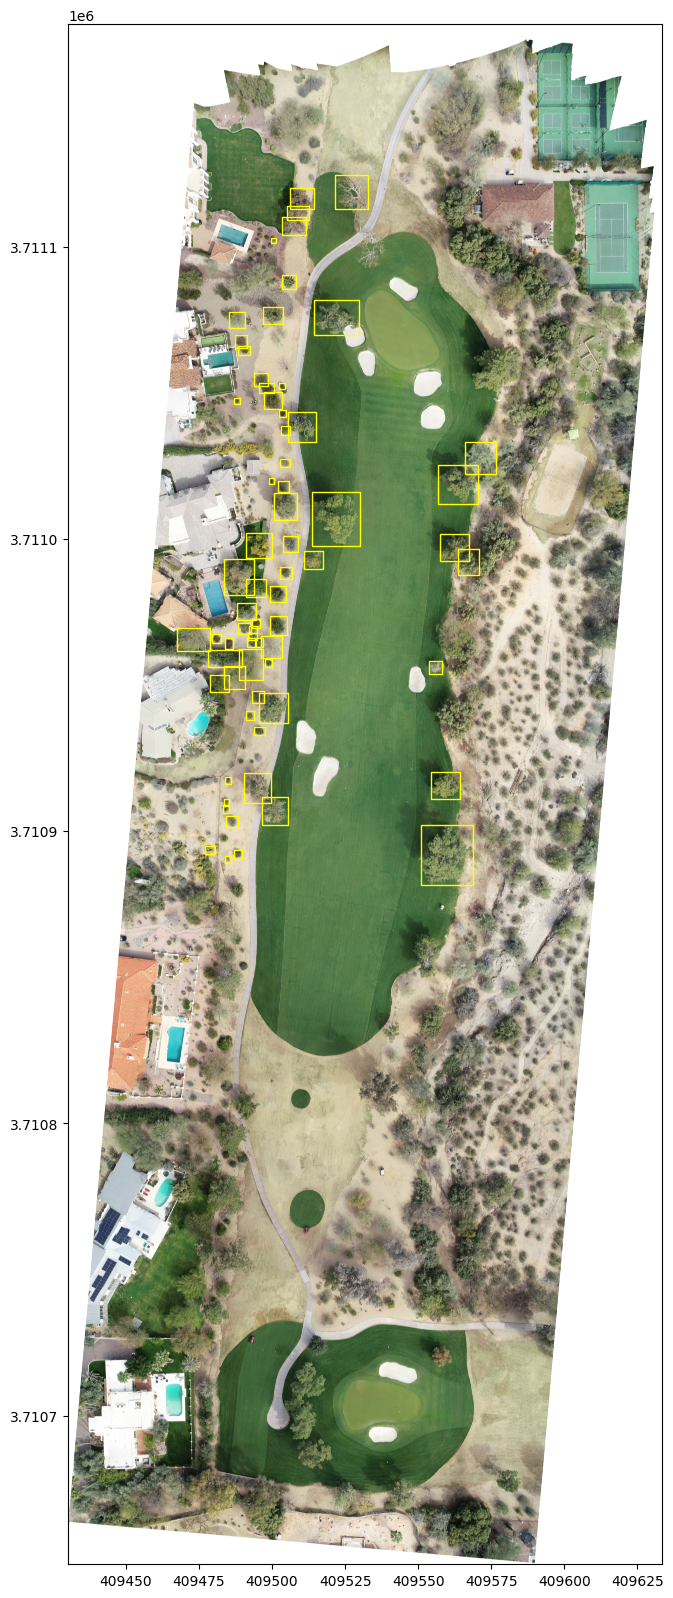

In [14]:
## Show shapefile overlayed on orthomosaic

# Open the GeoTIFF file
with rasterio.open(train_image_path) as src:
    fig, ax = plt.subplots(figsize=(20, 20))
    show(src, ax=ax)

    # Read the shapefile
    shapefile = gpd.read_file(shp_path)

    # Plot the shapefile on top of the GeoTIFF
    shapefile.plot(ax=ax, facecolor='none', edgecolor='yellow')

plt.show()

In [15]:
##Convert .shp (shapefile) to annoation that can be ingested by DeepForest
savedir = "/content"
df = shapefile_to_annotations(shapefile=shp_path, rgb=train_image_path, geometry_type='bbox', savedir=savedir)

In [16]:
#Write training annotation dataframe to csv file
df.to_csv(os.path.join(savedir, "labels_pixel_coords.csv"), index=False)

In [17]:
#Show the annotation
df

image_path  xmin   ymin  xmax   ymax label
0   hole_17_ortho_utm.tif  3655   8704  3899   8969  Tree
1   hole_17_ortho_utm.tif  4011   8958  4332   9254  Tree
2   hole_17_ortho_utm.tif  3502   7961  3894   8424  Tree
3   hole_17_ortho_utm.tif  3013   8653  3461   9075  Tree
4   hole_17_ortho_utm.tif  3604   9223  3802   9427  Tree
..                    ...   ...    ...   ...    ...   ...
63  hole_17_ortho_utm.tif  2323  13966  2486  14108  Tree
64  hole_17_ortho_utm.tif  2823  14037  2954  14179  Tree
65  hole_17_ortho_utm.tif  2660  14139  2762  14250  Tree
66  hole_17_ortho_utm.tif  2641  13169  2736  13280  Tree
67  hole_17_ortho_utm.tif  2633  13272  2739  13398  Tree

[68 rows x 6 columns]

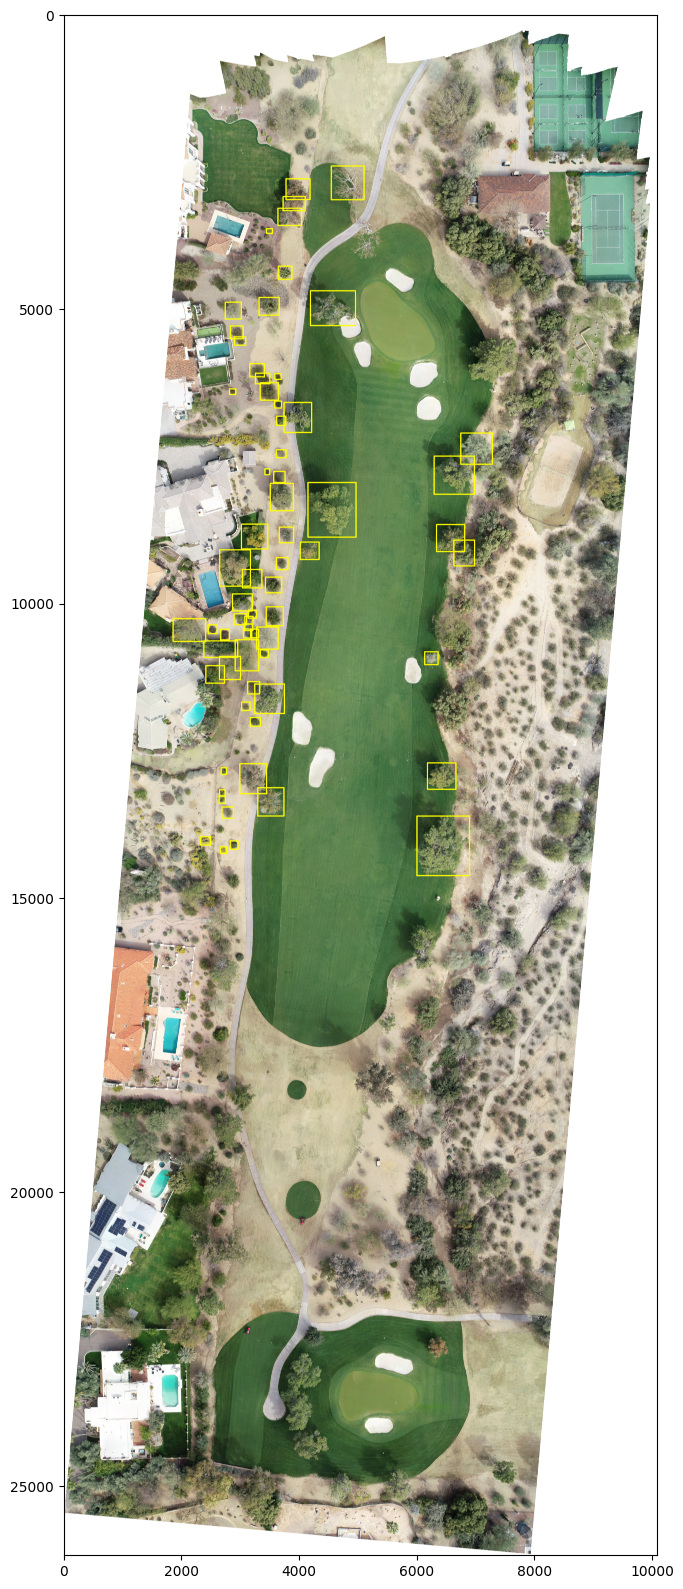

In [ ]:
## Display the annotation on the orthomosaic

rasterio_src = rasterio.open(train_image_path)

image = rasterio_src.read()
image = numpy.rollaxis(image, 0, 3)

fig = plot_predictions(image, df, color=(255, 255, 0), thickness=20)
plt.figure(figsize=(20, 20))
plt.imshow(fig)

In [18]:
##This will split a large georeferenced image (and it's labels) into smaller pieces. This prevents running out of memory.
annotation_path = os.path.join(savedir, "labels_pixel_coords.csv")

#create a directory where the smaller images will be stored
crop_dir = os.path.join(savedir, 'train_data')

# Do the split and write out the cropped images as .png files.
#Also write a new annotation table (csv) that lists all of the label coordinates and the cropped image they belong to.
output_crops = split_raster(path_to_raster=train_image_path,
                            annotations_file=annotation_path,
                            base_dir=crop_dir,
                            patch_size=1100,  #1100x1100 pixels
                            patch_overlap=0.25, #cropped image overlap. This is useful because label boxes may be on the edge of cropped images.
                            allow_empty=False)

print(f"Number of tree crown annotations: {len(output_crops)}")
output_crops

Number of tree crown annotations: 81


image_path  xmin  ymin  xmax  ymax label
26   hole_17_ortho_utm_76.png   798   465   950   615  Tree
56   hole_17_ortho_utm_76.png   202   360   756   746  Tree
52   hole_17_ortho_utm_77.png   759   334  1074   631  Tree
61   hole_17_ortho_utm_79.png  1018   419  1100   532  Tree
66   hole_17_ortho_utm_79.png   991   794  1086   905  Tree
..                        ...   ...   ...   ...   ...   ...
10  hole_17_ortho_utm_234.png   551   410  1030   869  Tree
39  hole_17_ortho_utm_237.png   351    98   577   316  Tree
57  hole_17_ortho_utm_239.png   397   336   881   785  Tree
8   hole_17_ortho_utm_264.png   139   505   674  1035  Tree
11  hole_17_ortho_utm_266.png    21   675   373  1100  Tree

[81 rows x 6 columns]

### Split annotation data into training and validation

In [19]:
#identify all of the cropped images as an array
image_paths = output_crops.image_path.unique()

#Of the unique cropped image paths, randomly select 25% of them
validation_paths = numpy.random.choice(image_paths, int(len(image_paths)*0.25))

#Get the individual tree annotation from the 25% cropped images
validation_annotations = output_crops.loc[output_crops.image_path.isin(validation_paths)]

#Get the individual tree annotations from the remaining 75% cropped images
train_annotations = output_crops.loc[~output_crops.image_path.isin(validation_paths)]

#Print out the number of training and testing tree crown annotations
train_annotations.head()
print("There are {} training crown annotations".format(train_annotations.shape[0]))
print("There are {} test crown annotations".format(validation_annotations.shape[0]))

There are 65 training crown annotations
There are 16 test crown annotations


In [20]:
## Write training and validation annotations to separate csv files

#save to file and create the file dir
training_file= os.path.join(crop_dir,"train.csv")
validation_file= os.path.join(crop_dir,"valid.csv")
#Write window annotations file without a header row, same location as the "base_dir" above.
train_annotations.to_csv(training_file,index=False)
validation_annotations.to_csv(validation_file,index=False)

## Train

In [21]:
##Set parameters for the training run

#Define the pre-trained model
model = main.deepforest()

model.config['gpus'] = '-1' #move to GPU and use all the GPU resources

#model.config["save-snapshot"] = False
#model.config["train"]["fast_dev_run"] = True

#The annotation table
model.config["train"]["csv_file"] = training_file
#The directory where the training imagery is located
model.config["train"]["root_dir"] = os.path.dirname(training_file)

model.config["score_thresh"] = 0.4
model.config["train"]['epochs'] = 4

model.config["validation"]["csv_file"] = validation_file
model.config["validation"]["root_dir"] = os.path.dirname(validation_file)


model.create_trainer()

model.use_release()


Reading config file: /usr/local/lib/python3.10/dist-packages/deepforest/data/deepforest_config.yml


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..


No validation file provided. Turning off validation loop
Model from DeepForest release https://github.com/weecology/DeepForest/releases/tag/1.0.0 was already downloaded. Loading model from file.


/usr/local/lib/python3.10/dist-packages/deepforest/main.py:130: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(self.release_state_dict))

Loading pre-built model: https://github.com/weecology/DeepForest/releases/tag/1.0.0


In [22]:
##TRAIN THE MODEL!
#You can watch the GPU usage by using nvtop (sudo apt install nvtop)
start_time = time.time()
model.trainer.fit(model)
print(f"--- Training on GPU: {(time.time() - start_time):.2f} seconds ---")

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type                  | Params | Mode 
-------------------------------------------------------------
0 | model      | RetinaNet             | 32.1 M | train
1 | iou_metric | IntersectionOverUnion | 0      | train
2 | mAP_metric | MeanAveragePrecision  | 0      | train
-------------------------------------------------------------
31.9 M    Trainable params
222 K     Non-trainable params
32.1 M    Total params
128.592   Total estimated model params size (MB)
204       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/albumentations/core/composition.py:161: UserWarning: Got processor for bboxes, but no transform to process it.
  self._set_keys()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 3. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
/usr/local/lib/python3.10/dist-packages/deepforest/evaluate.py:193: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat 

Training: |          | 0/? [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation: |          | 0/? [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation: |          | 0/? [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation: |          | 0/? [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=4` reached.
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


--- Training on GPU: 32.45 seconds ---


## Visualize the prediction after model fine-tuning

In [25]:
##Predict tree crowns on a georeferenced image
predicted_raster = fine_tuned_model.predict_tile(raster_path, return_plot = True, patch_size=1000, patch_overlap=0.25, color=(255, 255, 0), thickness=20)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


2186 predictions in overlapping windows, applying non-max supression
1208 predictions kept after non-max suppression


/usr/local/lib/python3.10/dist-packages/deepforest/visualize.py:118: UserWarning: Input images must be channels last format [h, w, 3] not channels first [3, h, w], using np.rollaxis(image, 0, 3) to invert!
  warnings.warn("Input images must be channels last format [h, w, 3] not channels "


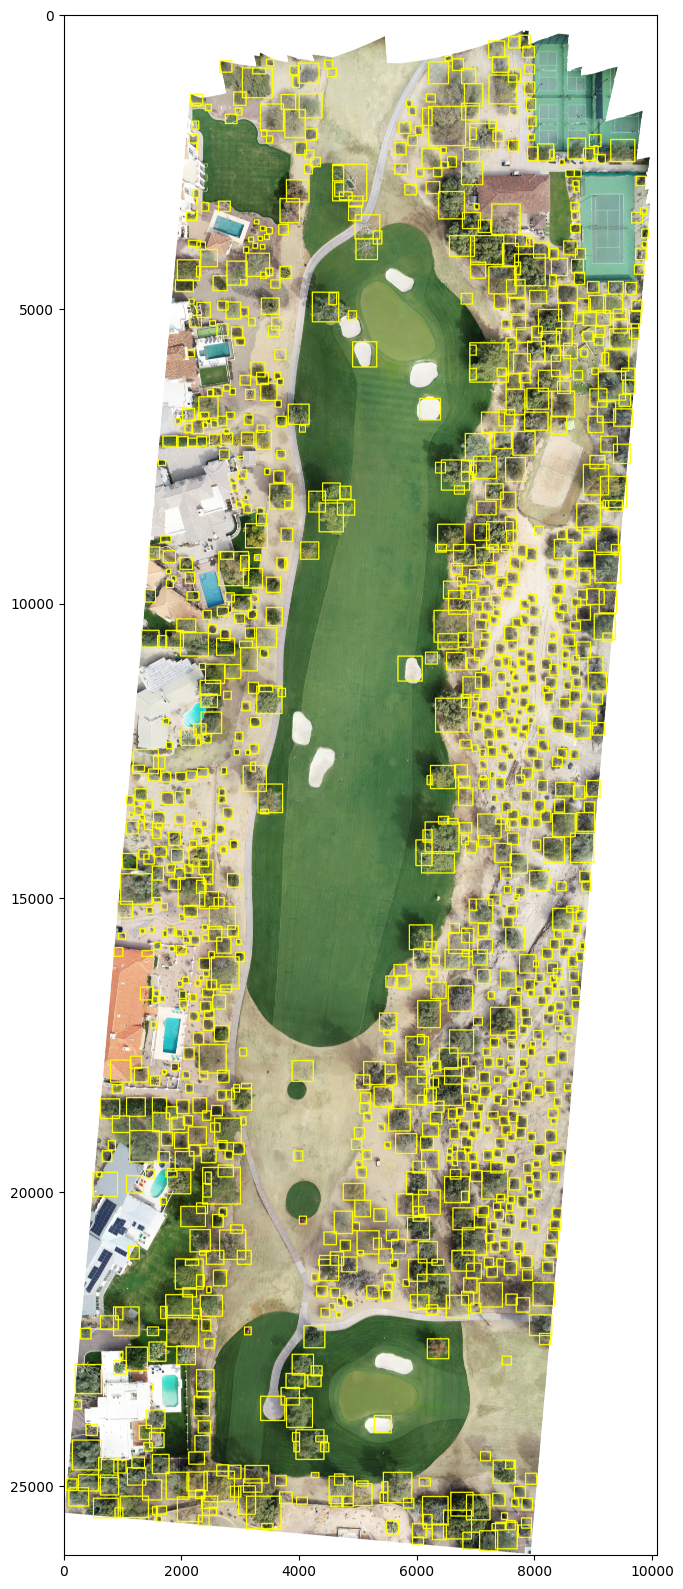

In [26]:
plt.figure(figsize=(20, 20))
plt.imshow(predicted_raster)
plt.show()

## Output and save prediction results for each image crop

In [ ]:
save_dir = os.path.join(savedir, 'pred_result')
os.makedirs(save_dir, exist_ok=True)
results = model.evaluate(training_file, os.path.dirname(training_file), iou_threshold = 0.4, savedir= save_dir)

/opt/conda/lib/python3.11/site-packages/albumentations/core/composition.py:144: UserWarning: Got processor for bboxes, but no transform to process it.
  self._set_keys()
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/opt/conda/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 26/26 [00:15<00:00,  1.72it/s]


/opt/conda/lib/python3.11/site-packages/deepforest/IoU.py:113: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  iou_df = pd.concat(iou_df)


In [ ]:
## Output and save validation results for each image crop

In [27]:
save_dir = os.path.join(savedir, 'valid_result')
os.makedirs(save_dir, exist_ok=True)
results = model.evaluate(validation_file, os.path.dirname(validation_file), iou_threshold = 0.4, savedir= save_dir)

/usr/local/lib/python3.10/dist-packages/albumentations/core/composition.py:161: UserWarning: Got processor for bboxes, but no transform to process it.
  self._set_keys()
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


## Assessing the Quality of our Tree Predictions

In [28]:
#show assessment of results
results

{'results':    prediction_id  truth_id       IoU     score  xmin  xmax  ymin  ymax  \
 0              0         0  0.810327  0.698754   538   986   403   825   
 0              1         0  0.793518  0.459710   333   733     0   278   
 1              0         1  0.825376  0.627581   139   239   331   412   
 0              4         0  0.924124  0.340673   278   394     0    80   
 1              1         1  0.841777  0.607316   312   467   219   374   
 2              2         2  0.653724  0.538781   436   906     0   495   
 3              0         3  0.770275  0.824956   304   470   790   924   
 0              1         0  0.700093  0.610614   355   599   454   719   
 1              0         1  0.817155  0.838483   711  1032   708  1004   
 0              0         0  0.765020  0.817638    36   168    66   198   
 0              0         0  0.822897  0.699517   798   950   465   615   
 1              1         1  0.543934  0.575407   202   756   360   746   
 0            

In [29]:
results['results']

prediction_id  truth_id       IoU     score  xmin  xmax  ymin  ymax  \
0              0         0  0.810327  0.698754   538   986   403   825   
0              1         0  0.793518  0.459710   333   733     0   278   
1              0         1  0.825376  0.627581   139   239   331   412   
0              4         0  0.924124  0.340673   278   394     0    80   
1              1         1  0.841777  0.607316   312   467   219   374   
2              2         2  0.653724  0.538781   436   906     0   495   
3              0         3  0.770275  0.824956   304   470   790   924   
0              1         0  0.700093  0.610614   355   599   454   719   
1              0         1  0.817155  0.838483   711  1032   708  1004   
0              0         0  0.765020  0.817638    36   168    66   198   
0              0         0  0.822897  0.699517   798   950   465   615   
1              1         1  0.543934  0.575407   202   756   360   746   
0              2         0  0.791729  0.656996   673   836   766   908   
1              1         1  0.835106  0.690891  1010  1100   939  1050   
2             14         2  0.758742  0.211442   991  1086     0    80   
3              4         3  0.899684  0.608633   983  1089    72   198   

  predicted_label true_label                 image_path  match  
0            Tree       Tree  hole_17_ortho_utm_106.png   True  
0            Tree       Tree  hole_17_ortho_utm_132.png   True  
1            Tree       Tree  hole_17_ortho_utm_132.png   True  
0            Tree       Tree  hole_17_ortho_utm_136.png   True  
1            Tree       Tree  hole_17_ortho_utm_136.png   True  
2            Tree       Tree  hole_17_ortho_utm_136.png   True  
3            Tree       Tree  hole_17_ortho_utm_136.png   True  
0            Tree       Tree  hole_17_ortho_utm_138.png   True  
1            Tree       Tree  hole_17_ortho_utm_138.png   True  
0            Tree       Tree  hole_17_ortho_utm_141.png   True  
0            Tree       Tree   hole_17_ortho_utm_76.png   True  
1            Tree       Tree   hole_17_ortho_utm_76.png   True  
0            Tree       Tree   hole_17_ortho_utm_80.png   True  
1            Tree       Tree   hole_17_ortho_utm_80.png   True  
2            Tree       Tree   hole_17_ortho_utm_80.png   True  
3            Tree       Tree   hole_17_ortho_utm_80.png   True

In [30]:
results['box_precision']

0.32335600907029477

In [31]:
results["box_recall"]

1.0

In [32]:
results["class_recall"]

label  recall  precision  size
0      0     1.0        1.0    16

## Save and load the fine-tuned model

In [23]:
#Save the fine-tuned model out to your storage
save_model_dir = os.path.join(savedir, 'golf_course_deepforest.pt')
torch.save(model.model.state_dict(),save_model_dir)

In [24]:
#Bring existing model into environment
fine_tuned_model = main.deepforest()
fine_tuned_model.model.load_state_dict(torch.load(save_model_dir))

Reading config file: /usr/local/lib/python3.10/dist-packages/deepforest/data/deepforest_config.yml


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


No validation file provided. Turning off validation loop


<ipython-input-24-061f15df8df6>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  fine_tuned_model.model.load_state_dict(torch.load(save_model_dir))


<All keys matched successfully>

## Save Fine-tuned model to Hugging Face

In [33]:
#Install python libraries that allow you to connect with Hugging Face
!pip install huggingface_hub

In [35]:
#Input your Hugging Face username toke to authenticate your account
from huggingface_hub import notebook_login

notebook_login()

In [41]:
#Push fine-tuned model up to Hugging Face
from huggingface_hub import HfApi

# Set up repository details
repo_name = "deepforest_fine_tuning"
model_file = "/content/golf_course_deepforest.pt"

# Create a new repo if it doesn't exist
#api = HfApi()
#api.create_repo(repo_name)

# Upload model to Hugging Face
api.upload_file(
    path_or_fileobj=model_file,   # Path to your .pt file
    repo_id=f"jgillan/{repo_name}",
    path_in_repo="golf_course_deepforest.pt"  # The name you want for the file on the Hub
)


golf_course_deepforest.pt:   0%|          | 0.00/129M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/jgillan/deepforest_fine_tuning/commit/ad8d60e401d83a5cf7c96c2f607768e36174aecd', commit_message='Upload golf_course_deepforest.pt with huggingface_hub', commit_description='', oid='ad8d60e401d83a5cf7c96c2f607768e36174aecd', pr_url=None, pr_revision=None, pr_num=None)

## Download a model from Hugging Face and bring into Colab

In [46]:

from huggingface_hub import hf_hub_download

# Download the .pt file from Hugging Face
model_file = hf_hub_download(repo_id="jgillan/deepforest_fine_tuning", filename="golf_course_deepforest.pt")

fine_tuned_model = main.deepforest()
fine_tuned_model.model.load_state_dict(torch.load(model_file))

golf_course_deepforest.pt:   0%|          | 0.00/129M [00:00<?, ?B/s]

Reading config file: /usr/local/lib/python3.10/dist-packages/deepforest/data/deepforest_config.yml


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


No validation file provided. Turning off validation loop


<ipython-input-46-425d7a9f8b5c>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  fine_tuned_model.model.load_state_dict(torch.load(model_file))


<All keys matched successfully>